# Grid and Pack

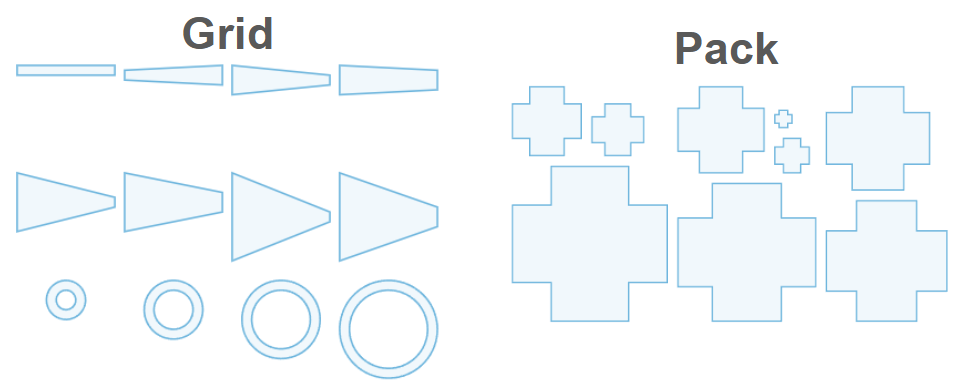

This notebook demonstrates how to arrange layout primitives and components using `photonforge.grid_layout()` and `photonforge.pack_layout()`. The [grid_layout](../_autosummary/photonforge.grid_layout.rst) function is ideal for creating structured arrays, such as parameter sweeps, with precise control over spacing and alignment. In contrast, [pack_layout](../_autosummary/photonforge.pack_layout.rst) provides a flexible way to efficiently organize a large number of arbitrary shapes into compact bins, optimizing space usage based on customizable heuristics. Together, these tools enable powerful layout automation workflows.


In [1]:
import numpy as np
import photonforge as pf

tech = pf.basic_technology()
pf.config.default_technology = tech

## Grid

The [grid_layout()](../_autosummary/photonforge.grid_layout.rst) function arranges a list (or 2D array) of objects—such as components, shapes, or references—into a structured grid. This is particularly useful for visualizing parameter sweeps or organizing elements for inspection and comparison.

In the following example, we create a diverse set of layout elements by combining linear tapers (with varying input/output widths) and circular rings (with varying radius). These are then arranged in a grid to demonstrate the flexibility and expressiveness of `grid_layout`.


In [2]:
from photonforge import Circle, grid_layout
from photonforge.stencil import linear_taper

# Create a list to hold taper components with different width combinations
shape_list = []
for width1 in [1, 3, 6, 9]:
    for width2 in [1, 2]:
        # Create a taper of length 10 with varying input/output widths
        D = linear_taper(length=10, widths=(width1, width2))
        shape_list.append(D)

# Add several circular rings to the shape list
for radius in [2, 3, 4, 5]:
    # Create a ring with given outer and inner radius
    ring = Circle(radius=radius, inner_radius=radius - 1)
    shape_list.append(ring)

# Arrange all shapes in a grid
c = grid_layout(shape_list)

# Visualize the arranged grid layout
c

You can control the grid layout using several arguments:
- `gap` sets horizontal and vertical spacing between items.
- `shape` defines the number of columns and rows in the grid.
- `align_x` and `align_y` control the alignment of each object within its grid cell.
- `direction` specifies the order in which items fill the grid (e.g., left-to-right then top-to-bottom).
- `layer` assigns a common layer to all included geometry if applicable.


In [3]:
# Set 1 unit gap, align left/top, direction left-to-right then top-to-bottom
# Add resulting layout to layer (2, 0)
c = grid_layout(
    shape_list,
    gap=(1, 1),
    shape=(4, 3),
    align_x="center",
    align_y="top",
    direction="lr-tb",
    layer=(2, 0),
)

# Visualize the arranged grid layout
c

## Pack

The [pack_layout()](../_autosummary/photonforge.pack_layout.rst) function arranges a sequence of objects—such as components, shapes, or references—into one or more rectangular bins, optimizing for space utilization. This is especially useful when you need to fit a collection of primitives into a constrained area or when exploring different packing heuristics.

In the following example, we construct a list of cross-shaped primitives with increasing arm lengths, then pack them into a bin without explicit size limits. The result shows how we can efficiently place all shapes into a single packed component.


In [4]:
from photonforge import pack_layout
from photonforge.stencil import cross

# Set random seed for reproducibility
np.random.seed(4)

# Create a list of crosses with varying arm lengths and widths
D_list = [cross(arm_length=i, arm_width=i) for i in range(1, 10)]

# Pack the crosses into bins
D_packed_list = pack_layout(D_list)

# Extract the first packed component (only one bin created)
D = D_packed_list[0]

# Visualize the packed layout
D

You can control the packing behavior with several arguments:
- `gap` sets the minimum distance between adjacent items.
- `aspect_ratio` defines the desired width:height ratio of each bin.
- `grow_factor` determines how aggressively the bin size increases during packing; values closer to 1 yield tighter fits at the cost of extra computation.
- `sorting` specifies how to order objects before packing (e.g., `"area"` to place larger items first).
- `allow_rotation` enables or disables 90° rotations of shapes to improve fit.
- `method` selects a heuristic for choosing free slots (e.g., `"blsf"` for Best Long Side Fit).
- `layer` assigns a common layer to all packed geometry if desired.
- `name` provides a template for naming bins when multiple are generated.

In [5]:
# Pack the crosses into bins with specified parameters
D_packed_list = pack_layout(
    D_list,  # List of shapes to pack
    gap=1.25,  # Minimum distance between adjacent shapes
    aspect_ratio=2,  # Desired width:height ratio of each bin
    grow_factor=1.05,  # Controls incremental bin size increase
    sorting="area",  # Sort shapes by area before packing
    method="blsf",  # Use best long side fit heuristic
    allow_rotation=False,  # Do not rotate shapes during packing
    layer=(2, 0),
)

# Extract the first packed component (only one bin created)
D = D_packed_list[0]

# Visualize the packed layout
D


As another example, we define a parametric component that connects two grating couplers using an `s_bend` waveguide. 

In [6]:
from photonforge.parametric import s_bend
from photonforge.stencil import as_component


@pf.parametric_component()
# Define a parametric component: 2 gratings connected by an s-bend
def s_bend_grating(length=20.0, offset=5.0):
    c = pf.Component()

    # Create the first grating component using the stencil
    grating = as_component(
        stencil="grating",
        layer=(2, 0),
        period=0.6,
        num_periods=10,
        width=5,
        taper_length=10,
        taper_width=0.5,
    )

    # Add a slab layer around the grating using envelope
    slab = pf.envelope(
        grating,
        offset=1,
        trim_x_min=True,
        trim_x_max=True,
    )
    grating.add((1, 0), slab)

    # Automatically detect and assign ports to the grating
    grating.add_port(grating.detect_ports([tech.ports["Strip"]]))

    # Add two grating references to the main component
    g_ref1 = c.add_reference(grating)
    g_ref2 = c.add_reference(grating)

    # Create an s-bend with specified length and offset
    sb = s_bend(port_spec="Strip", length=length, offset=offset)
    ref_sb = c.add_reference(sb)

    # Connect s-bend input to first grating and output to second grating
    ref_sb.connect("P0", g_ref1["P0"])
    g_ref2.connect("P0", ref_sb["P1"])

    return c


# Instantiate the component and visualize it
c = s_bend_grating()
c


As an example, assume that we want to evaluate different s-bend geometries on a single test chip, we generate 100 instances of the `s_bend_grating` component with randomized `length` and `offset` parameters. We then use `pack_layout()` to efficiently organize these instances within a confined chip area. The packing function ensures that the layout is space-efficient, adheres to spacing constraints, and splits the components into bins if necessary. This approach is ideal for layout prototyping and measurement-ready chip designs.


In [7]:
# Set a random seed for reproducibility
np.random.seed(2)

# Create a list of s-bend grating components with random length and offset
D_list = []
for n in range(100):
    (length, offset) = tuple(np.random.rand(2) * n + 2)
    sg = s_bend_grating(length=length, offset=offset)
    D_list.append(sg)

# Pack the components into bins using spatial heuristics
D_packed_list = pack_layout(
    D_list,  # List of s-bend grating components to pack
    gap=5,  # Minimum spacing between adjacent components
    aspect_ratio=1,  # Use square bins
    max_size=(400, 400),  # Limit bin size to 400×400
    grow_factor=1.1,  # Controls bin size growth during packing
    sorting="best",  # Use smart heuristic for placement order
    method="bssf",  # Best Short Side Fit for packing efficiency
)

# Print how many bins were created during packing
print(len(D_packed_list))

2


In [8]:
c = pf.grid_layout(D_packed_list)
c